# Estimer une probabilité de dépassement de seuil - Application au cas de la poutre en flexion


## Déviation  verticale d'une poutre encastrée

On considère une poutre encastrée de longueur $L$ et de section $I$. La poutre est définie par son module de Young $E$. Une extrémité est encastrée et on applique une charge ponctuelle $F$ à l'autre extrémité de la poutre, ce qui provoque une déviation verticale $Y$.

<img src="poutre.png" width="200">

__Inputs__:  $\left\{ E, F, L, I \right\}$
* $E$ : Young modulus (Pa)
* $F$ : Loading (N),
* $L$ : Length of beam (cm),
* $I$ : Moment of inertia (cm^4).

|Variable|  Distribution|
| ------------- |-------------|
|E|  Beta(r = 0.9, t = 3.5, a = $2.5\times 10^7$, $b = 5\times 10^7$) |
|F| Lognormal($\mu_F=3 \times 10^4$, $\sigma_F=9\times 10^3$, shift=$15\times 10^3$)|
|L|Uniform(min=250.0, max= 260.0)|
|I| Beta(r = 2.5, t = 1.5, a = 310, b = 450)|

Dans la table précedente $\mu_F=E(F)$ et $\sigma_F=\sqrt{V(F)}$ sont les moyenne et l'écart-type de $F$.

Les variables d'entrée sont indépendantes.

__Output__:

La déviation verticale à l'extrémité libre de la poutre est:
$$
Y  = \dfrac{F\, L^3}{3 \, E \, I}
$$
Une déviation de 30 cm ou plus est considérée comme problématique.
$$
Y \geq 30 \textrm{ (cm)}
$$
Avec un échantillon de Monte-Carlo de taille 7 120 000, on obtient:
$$
P(Y\geq 30) = 0.005590.
$$
L'intervalle de confiance à 95% est 
$$
P([0.005536,0.005645]\ni P_f)=0.95.
$$

# Model definition

In [1]:
import openturns as ot
import numpy as np

In [2]:
dist_E = ot.Beta(0.9, 3.1, 2.8e7, 4.8e7)
dist_E.setDescription(["E"])
F_para = ot.LogNormalMuSigma(3.0e4, 9.0e3, 15.0e3) # in N
dist_F = ot.ParametrizedDistribution(F_para)
dist_F.setDescription(["F"])
dist_L = ot.Uniform(250., 260.) # in cm
dist_L.setDescription(["L"])
dist_I = ot.Beta(2.5, 1.5, 310., 450.) # in cm^4
dist_I.setDescription(["I"])

X = ot.ComposedDistribution([dist_E, dist_F, dist_L, dist_I])

In [3]:
g = ot.SymbolicFunction( ["E","F","L","I"],["F* L^3 /  (3 * E * I)"])
g.setOutputDescription(["Y (cm)"])

Pour pouvoir exploiter au mieux les simulations, nous équipons la fonction d'un méchanisme d'historique.

In [4]:
g = ot.MemoizeFunction(g)

Enfin, nous définissons le vecteur aléatoire de sortie.

In [5]:
XRV = ot.RandomVector(X)
Y = ot.CompositeRandomVector(g, XRV)
Y.setDescription(['Y (cm)'])

## Par Monte-Carlo simple avec un budget fixé

La manière la plus simple de faire une telle étude consiste à fixer le nombre de simulations à l'avance. En d'autres termes, on fixe $n$ et on génère un échantillon de la variable de sortie $Y$ de taille $n$. C'est la méthode "traditionnelle".

In [6]:
n = 10000

In [7]:
Ysample = Y.getSample(n)

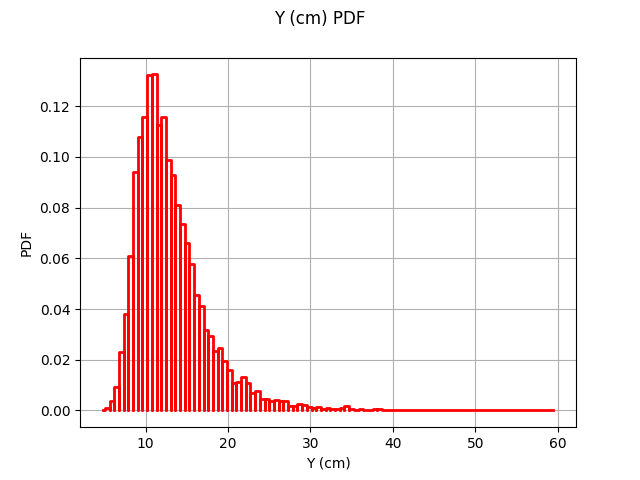

In [8]:
graph = ot.HistogramFactory().build(Ysample).drawPDF()
graph.setXTitle("Y (cm)")
graph.setLegends([""])
graph

La probabilité recherchée peut être calculée en évaluant la fonction de répartition complémentaire de l'échantillon.

In [9]:
pf = Ysample.computeEmpiricalCDF([30.],True)
pf

0.0069

In [10]:
alpha = 0.05

In [11]:
sigmapf = np.sqrt(pf*(1-pf)/n)
sigmapf

0.0008277916404506632

In [12]:
pf_dist = ot.Normal(pf,sigmapf)
pf_dist

class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0.0069] sigma=class=Point name=Unnamed dimension=1 values=[0.000827792] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1]

In [13]:
bounds = pf_dist.computeBilateralConfidenceInterval(1-alpha)
lb = bounds.getLowerBound()[0]
up = bounds.getUpperBound()[0]
print("%.2f%% confidence interval = [%f,%f]" % ((1-alpha)*100,lb,up))

95.00% confidence interval = [0.005278,0.008522]


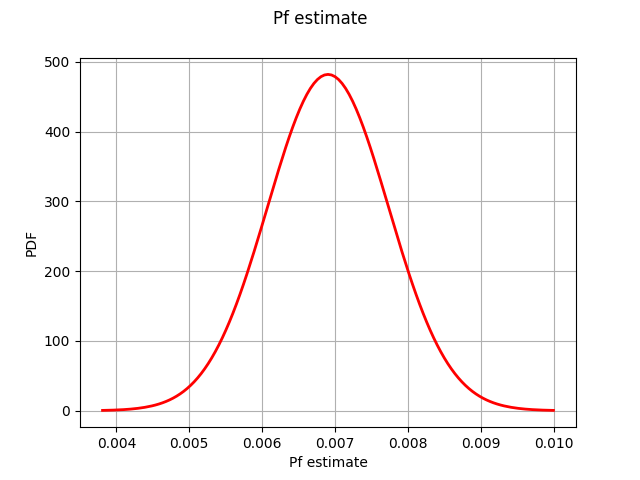

In [14]:
graph = pf_dist.drawPDF()
graph.setXTitle("Pf estimate")
graph.setTitle("Pf estimate")
graph.setLegends([""])
graph

## Par Monte-Carlo avec un algorithme itératif

La classe `ProbabilitySimulationAlgorithm` permet de calculer une probabilité avec une précision fixée par l'utilisateur en utilisant la taille d'échantillon $n$ la plus petite possible.

In [15]:
myEvent = ot.ThresholdEvent(Y, ot.Greater(), 30.0)

In [16]:
blocksize = 1000
experiment = ot.MonteCarloExperiment()
myAlgo = ot.ProbabilitySimulationAlgorithm(myEvent, experiment)
myAlgo.setMaximumOuterSampling(10000)
myAlgo.setBlockSize(blocksize)
myAlgo.setMaximumCoefficientOfVariation(0.01)

In [17]:
myAlgo.run()

In [18]:
result = myAlgo.getResult()

In [19]:
outersampling = result.getOuterSampling()
outersampling

1499

In [20]:
funccalls = blocksize * outersampling
funccalls

1499000

In [21]:
pf = result.getProbabilityEstimate()
pf

0.006634422948632383

In [22]:
alpha = 0.05

In [23]:
pflen = result.getConfidenceLength(1-alpha)
print("%.2f%% confidence interval = [%f,%f]" % ((1-alpha)*100,pf-pflen/2,pf+pflen/2))

95.00% confidence interval = [0.006504,0.006764]


## Exercice 1 : sensibilité aux paramètres
 
 L'objectif de cet exercice est d'utiliser la classe `ProbabilitySimulationAlgorithm`, de comprendre ses paramètres et interpréter ses résutlats.
 - Créer une fonction `calculePF` qui prend en argument le seuil `threshold` et le coefficient de variation `coeffofvar`. Dans le corps de la fonction, utiliser la classe `ProbabilitySimulationAlgorithm` et calculer, puis afficher :
   - la probabilité de dépassement de seuil $p_f$, 
   - l'intervalle de confiance à 95% et 
   - le nombre d'appels à la fonction $g$.
   
Pour vous aider, vous pouvez vous inspirer du squelette suivant, dans lequel vous remplacerez les sections *TODO* par du code Python valide.

```
def calculePF(threshold,coeffofvar):
    print("Seuil = %f, C.V. = %f" % (threshold,coeffofvar))
    myEvent = ot.Event(TODO)
    experiment = ot.MonteCarloExperiment()
    myAlgo = ot.ProbabilitySimulationAlgorithm(TODO)
    myAlgo.setMaximumOuterSampling(TODO)
    myAlgo.setBlockSize(TODO)
    myAlgo.setMaximumCoefficientOfVariation(TODO)
    myAlgo.run()
    result = TODO
    pf = TODO
    alpha = TODO
    pflen = result.TODO
    outersampling = result.TODO
    funccalls = TODO
    print("    Outersampling = %d, Nb. function G calls = %d" % (outersampling,funccalls))
    print("    Pf = %f" % (pf))
    print("    %.2f%% confidence interval = [%f,%f]" % ((1-alpha)*100,pf-pflen/2,pf+pflen/2))
    return None
```

 - Pour les valeurs du seuil égales à 10, 20 et 30 cm et CV=0.01, utiliser la fonction fonction `calculePF`. Pour interpréter vos résultats, présentez-les dans une table. Qu'observez-vous ? Expliquer le sens physique du résultat. 
 - On considère un seuil égal à s=30 cm. Configurer le coefficient de variation à 0.1, 0.05 et 0.01 et calculer le nombre d'appel à la fonction $g$. Pour interpréter vos résultats, présentez-les dans une table. Qu'observez-vous ? Expliquer pourquoi ce résultat est en lien avec le fonctionnement de l'algorithme.

## Solution de l'exercice 1 : sensibilité aux paramètres

In [28]:
def calculePF(threshold,coeffofvar):
    print("Seuil = %f, C.V. = %f" % (threshold,coeffofvar))
    myEvent = ot.ThresholdEvent(Y, ot.Greater(), threshold)
    experiment = ot.MonteCarloExperiment()
    myAlgo = ot.ProbabilitySimulationAlgorithm(myEvent, experiment)
    myAlgo.setMaximumOuterSampling(10000)
    blocksize = 1000
    myAlgo.setBlockSize(blocksize)
    myAlgo.setMaximumCoefficientOfVariation(coeffofvar)
    myAlgo.run()
    result = myAlgo.getResult()
    pf = result.getProbabilityEstimate()
    alpha = 0.05
    pflen = result.getConfidenceLength(1-alpha)
    outersampling = result.getOuterSampling()
    funccalls = blocksize * outersampling
    print("    Outersampling = %d, Nb. function G calls = %d" % (outersampling,funccalls))
    print("    Pf = %f" % (pf))
    print("    %.2f%% confidence interval = [%f,%f]" % ((1-alpha)*100,pf-pflen/2,pf+pflen/2))
    return None

In [29]:
calculePF(10,0.01)
calculePF(20,0.01)
calculePF(30,0.01)

Seuil = 10.000000, C.V. = 0.010000
    Outersampling = 4, Nb. function G calls = 4000
    Pf = 0.768000
    95.00% confidence interval = [0.754912,0.781088]
Seuil = 20.000000, C.V. = 0.010000
    Outersampling = 138, Nb. function G calls = 138000
    Pf = 0.067884
    95.00% confidence interval = [0.066556,0.069212]
Seuil = 30.000000, C.V. = 0.010000
    Outersampling = 1480, Nb. function G calls = 1480000
    Pf = 0.006720
    95.00% confidence interval = [0.006588,0.006851]


La table suivante présente les résultats que l'on obtient avec CV=0.01 et différentes valeurs du seuil $s$. 

| s (cm) | CV | $p_f$ | I.C. à 95% | Nb. appels à g |
|---|---|---|---|---|
| 10 (cm) | 0.01 | 0.717800 | [0.7053,0.7303] | 5000 |
| 20 (cm) | 0.01 | 0.058210 | [0.05707,0.05935] | 162000 |
| 30 (cm) | 0.01 | 0.005519 | [0.005411,0.005628] | 1804000 |

On observe que, lorsque le seuil augmente, 
- la probabilité diminue, 
- le nombre d'appels à la fonction $g$ augmente.

Le fait que la probabilité diminue lorsque le seuil augmente est cohérent avec la queue droite de la distribution de la déviation $Y$, avec de rares grandes déviations. 

Le fait que le nombre d'appels à $g$ augmente lorsque le seuil augmente est une conséquence de l'algorithme utilisé par `ProbabilitySimulationAlgorithm`, dans lequel nous avons fixé le coefficient de variation à 0.01. Ainsi, puisque la probabilité est de plus en plus proche de zéro, l'algorithme est contraint d'augmenter la taille de l'échantillon pour atteindre le coefficient de variation imposé.

In [30]:
calculePF(30,0.1)
calculePF(30,0.05)
calculePF(30,0.01)

Seuil = 30.000000, C.V. = 0.100000
    Outersampling = 15, Nb. function G calls = 15000
    Pf = 0.006867
    95.00% confidence interval = [0.005544,0.008189]
Seuil = 30.000000, C.V. = 0.050000
    Outersampling = 62, Nb. function G calls = 62000
    Pf = 0.006516
    95.00% confidence interval = [0.005882,0.007150]
Seuil = 30.000000, C.V. = 0.010000
    Outersampling = 1524, Nb. function G calls = 1524000
    Pf = 0.006531
    95.00% confidence interval = [0.006403,0.006659]


La table suivante présente les résultats que l'on obtient avec s=30 et différentes valeurs du coefficient de variation. 

| s (cm) | CV | $p_f$ | I.C. à 95% | Nb. appels à g |
|---|---|---|---|---|
| 30 (cm) | 0.1 | 0.005632 | [0.004567,0.006696] | 19000 |
| 30 (cm) | 0.05 | 0.005556 | [0.005012,0.006099] | 72000 |
| 30 (cm) | 0.01 | 0.005657 | [0.005546,0.005768] | 1760000 |

On observe que, lorsque le coefficient de variation diminue, le nombre d'appels à $g$ augmente considérablement. On observe également que la largeur de l'intervalle de confiance diminue. 

Cela est cohérent avec le résultat que nous avons présenté et qui montre que le nombre d'appels à $g$ dépend de l'inverse du carré de CV. C'est la raison pour laquelle, même si $CV=0.01$ semble un minimum acceptable, on se contente souvent de $CV=0.1$.

## Exercice 2 : probabilité en fonction du seuil

L'objectif de cet exercice est d'observer l'évolution de la probabilité lorsque le seuil augmente. Pour cela, on utilise un échantillon de taille fixé. 
- Créer la variable `Ysample` contenant un échantillon de $Y$ de taille 100000. 
- Créer la variable `thresholdarray` contenant 10 valeurs de $s$ entre 20 et 50. 
- Pour chaque valeur de seuil $s$, calculer 
  - la probabilité de dépassement de seuil,
  - la borne inférieure de l'intervalle de confiance,
  - la borne supérieure de l'intervalle de confiance.

Pour vous aider, vous pouvez vous inspirer du squelette suivante, dans lequel vous remplacerez les sections *TODO* par du code Python valide.

```
alpha = 0.05
nbthresholds = 10
thresholdarray = ot.Sample(np.linspace(20.,50.,nbthresholds),1)
pfarray = ot.Sample(nbthresholds,1)
lbarray = ot.Sample(nbthresholds,1)
ubarray = ot.Sample(nbthresholds,1)
for i in range(nbthresholds):
    s = thresholdarray[i,0]
    pf = TODO
    pfarray[i,0] = pf
    sigmapf = TODO
    pf_dist = TODO
    bounds = pf_dist.computeBilateralConfidenceInterval(1-alpha)
    lbarray[i,0] = bounds.getLowerBound()[0]
    ubarray[i,0] = bounds.getUpperBound()[0]
    print("s=%f, pf=%f in [%f,%f]" % (s,pf,lbarray[i,0],ubarray[i,0]))
```

- Créer un graphique réprésentant en abscisse le seuil $s$, et en ordonnée la probabilité de dépassement de seuil et ses bornes inférieures et supérieures.
  - Utiliser les méthodes `graph` et `curve` pour afficher les courbes (la syntaxe `myGraph.add(myCurve)` permet de rajouter des courbes au graph).
  - Utiliser la méthode `setLogScale` pour dessiner l'axe des ordonnées en échelle logarithmique.
  - Qu'observez-vous ? Expliquer-le sur le plan physique et sur le plan probabiliste.
- On s'intéresse au coefficient de variation :
$$
CV = \frac{\sigma_{p_f}}{p_f}
$$
si $p_f>0$ et son approximation :
$$
\widetilde{CV} = \frac{\tilde{\sigma}_{p_f}}{\tilde{p_f}}
$$
si $\tilde{p_f}>0$. 
Le coefficient de variation représente la précision relative d'estimation de la probabilité $p_f$. 
  - Pour chaque valeur de seuil $s$, calculer le coefficient de variation approché. Qu'observez-vous ? Pourquoi ?

Pour vous aider, vous pouvez vous inspirer du squelette suivante, dans lequel vous remplacerez les sections *TODO* par du code Python valide.

```
for i in range(nbthresholds):
    s = thresholdarray[i,0]
    pf = TODO
    pfarray[i,0] = pf
    sigmapf = TODO
    cv = TODO
    print("s=%f, pf=%f, C.V.=%f" % (s,pf,cv))
```

## Solution de l'exercice 2 : probabilité en fonction du seuil

In [31]:
n = 100000
Ysample = Y.getSample(n)

In [47]:
nbthresholds = 10
ff=np.linspace(20.,50.,nbthresholds)
thresholdarray = ot.Sample(np.array([np.linspace(20.,50.,nbthresholds)]).transpose())
thresholdarray

,v0
0,20
1,23.33333
2,26.66667
3,30
4,33.33333
5,36.66667
6,40
7,43.33333
8,46.66667
9,50


In [49]:
alpha = 0.05
nbthresholds = 10
thresholdarray = ot.Sample(np.array([np.linspace(20.,50.,nbthresholds)]).transpose())
pfarray = ot.Sample(nbthresholds,1)
lbarray = ot.Sample(nbthresholds,1)
ubarray = ot.Sample(nbthresholds,1)
for i in range(nbthresholds):
    s = thresholdarray[i,0]
    pf = Ysample.computeEmpiricalCDF([s],True)
    pfarray[i,0] = pf
    sigmapf = np.sqrt(pf*(1-pf)/n)
    pf_dist = ot.Normal(pf,sigmapf)
    bounds = pf_dist.computeBilateralConfidenceInterval(1-alpha)
    lbarray[i,0] = bounds.getLowerBound()[0]
    ubarray[i,0] = bounds.getUpperBound()[0]
    print("s=%f, pf=%f in [%f,%f]" % (s,pf,lbarray[i,0],ubarray[i,0]))

s=20.000000, pf=0.067840 in [0.066281,0.069399]
s=23.333333, pf=0.029420 in [0.028373,0.030467]
s=26.666667, pf=0.013630 in [0.012911,0.014349]
s=30.000000, pf=0.006360 in [0.005867,0.006853]
s=33.333333, pf=0.003020 in [0.002680,0.003360]
s=36.666667, pf=0.001500 in [0.001260,0.001740]
s=40.000000, pf=0.000950 in [0.000759,0.001141]
s=43.333333, pf=0.000540 in [0.000396,0.000684]
s=46.666667, pf=0.000350 in [0.000234,0.000466]
s=50.000000, pf=0.000140 in [0.000067,0.000213]


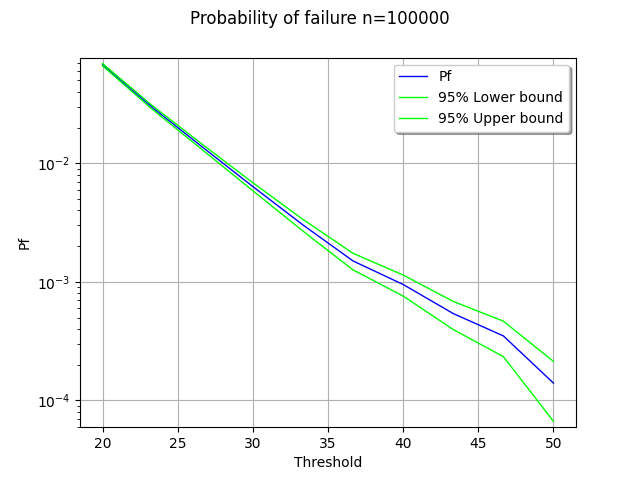

In [50]:
myGraph = ot.Graph('Probability of failure n=%d' % (n), 'Threshold', 'Pf', True, 'topright')
myPfCurve = ot.Curve(thresholdarray,pfarray, 'Pf')
myLBCurve = ot.Curve(thresholdarray,lbarray, 'Lower')
myLBCurve.setColor("green")
myUBCurve = ot.Curve(thresholdarray,ubarray, 'Upper')
myUBCurve.setColor("green")
myGraph.add(myPfCurve)
myGraph.add(myLBCurve)
myGraph.add(myUBCurve)
myGraph.setLegends(["Pf","95% Lower bound","95% Upper bound"])
myGraph.setLogScale(ot.GraphImplementation.LOGY)
myGraph

On observe que, lorsque le seuil $s$ augmente, alors la probabilité $p_f$ diminue. Cela montre que l'évènement recherché est de plus en plus rare. C'est physiquement cohérent, puisque les grandes déviations verticales sont moins fréquentes. C'est cohérent avec la distribution des déviations verticales, qui sont moins fréquentes lorsque la déviation augmente. 

In [51]:
for i in range(nbthresholds):
    s = thresholdarray[i,0]
    pf = Ysample.computeEmpiricalCDF([s],True)
    pfarray[i,0] = pf
    sigmapf = np.sqrt(pf*(1-pf)/n)
    cv = sigmapf/pf
    print("s=%f, pf=%f, C.V.=%f" % (s,pf,cv))

s=20.000000, pf=0.067840, C.V.=0.011722
s=23.333333, pf=0.029420, C.V.=0.018163
s=26.666667, pf=0.013630, C.V.=0.026901
s=30.000000, pf=0.006360, C.V.=0.039526
s=33.333333, pf=0.003020, C.V.=0.057457
s=36.666667, pf=0.001500, C.V.=0.081588
s=40.000000, pf=0.000950, C.V.=0.102549
s=43.333333, pf=0.000540, C.V.=0.136046
s=46.666667, pf=0.000350, C.V.=0.169001
s=50.000000, pf=0.000140, C.V.=0.267243


On observe que le coefficient de variation augmente lorsque la probabilité se rapproche de zéro. Cela est cohérent avec le calcul théorique qui indique $CV \approx \sqrt{\frac{1}{p_f n}}$ quand $p_f\approx 0$.